# JobSeekerAgency: an Agentic Workflow to make the whole process of find your next dream job effortless

In [2]:
import sys
sys.path.append('../python')
sys.path.append('../../keys')

In [3]:
%load_ext autoreload
%autoreload 2

import os
import subprocess as sub

## Custom scripts:
import Constants as C
from nodes_edges import *
from tools import *

## langchain:
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver, InMemorySaver
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain.tools import tool

## LLMs from providers:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

## Langgraph:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

## Typing
from pydantic import BaseModel, Field
from typing import List,Sequence,TypedDict,Annotated,Literal

## Visualize the graph:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
os.environ['OPENAI_API_KEY'] = C.OPENAI_API_KEY
os.environ['SERPAPI_API_KEY'] = C.SERPAPI_API_KEY # make sure it spelled as: SERPAPI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = C.ANTHROPIC_API_KEY

In [5]:
tools  = [get_NOVARTIS_jobs,get_AWS_jobs,get_YPSOMED_jobs]
# tools_by_name = {tool.name: tool for tool in tools}

In [27]:
class ChatMessages(TypedDict):
    
    messages: Annotated[Sequence[BaseMessage],add_messages] # the BaseMessages for agents
    company: str
    codescript: str # the script written by code-writer agent
    codeiter: int # keeps track of many times code has been modified
    joblist: str # the job list results from parsing career page
    # mytools: List[{}] # the list of tools to access the company jobs # !! YOU CANNOT PASS TOOLS HERE, OTHERWISE ERROR!!
    company2careerpage: dict # associates the company with their jobs postings

pass
## Nodes / Agents
## --------------------------------------------------

def call_agent(state):
    """
    First pass to know what to do, if it cannot find a tool to extract job list, then refer to code-writing agent
    """

    print(f'>> 0. First pass >>')

    system_message = SystemMessage(content="""You are a helpful assistant tasked with retrieving a job list.
    If you manage to extract the job list, please output it without any further comments, otherwise please just respond 'No' without any other comment.
    """) # 
    
    model    = ChatAnthropic(model="claude-sonnet-4-5",temperature=0).bind_tools(tools)
    # model    = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)
    
    if 11<3:

        state["messages"].append(system_message)
        
        ## preping the agent with tools
        prompt   = ChatPromptTemplate.from_messages(state["messages"]).format()
        # print(prompt)
        # prompt     = ChatPromptTemplate.from_messages([SystemMessage(content="You are a helpful assistant tasked with retrieving a job list")]+ state["messages"])
        
         # you are calling the llm here!
        response = model.invoke(prompt)
        state['messages'].append(response)
        return state
    else:
        response = { "messages": [model.invoke([system_message]+ state["messages"])] }
        return response

## Bifurcation / conditional edges
## --------------------------------------------------

def Are_tools_used(state)-> Literal['tools','codeWriter','formatter']:
    
    print('>> 0.1 Are tools used?')
    
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        print('> 0.2 calling tool')
        # return END
        return "tools"
    elif last_message.content == 'No':
        print('> 0.3 proceeding to code writing')
        return "codeWriter"
    return 'formatter'
    
def Is_code_ok_YN(state) -> Literal['codeWriter',END]:
    """
    If the code did not pass all desirability criteria, returns to code writer for correction
    """
    messages = state['messages']
    
    print('>> Is_code_ok_YN >>')
    
    last_message = state['messages'][-1].content
    # if 
    if last_message == 'Yes' or state['codeiter'] > 10:
        print('> calling tools\n')
        return END # calls the tools node here
    else:
        print('> returning code to code writer')
        return 'codeWriter'
        
    return END

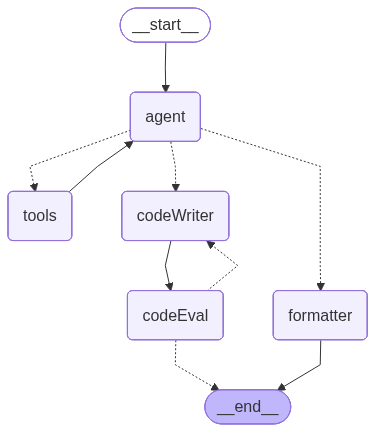

In [28]:
tool_node = ToolNode(tools)

workflow  = StateGraph(ChatMessages)

## adding nodes
workflow.add_node('agent',call_agent)
workflow.add_node('tools',tool_node)
workflow.add_node('formatter',joblist_formatting)

## adding edges and routing
workflow.add_edge(START,'agent')
workflow.add_conditional_edges('agent',Are_tools_used) # setting router function for the agent
workflow.add_edge('tools','agent') # you want to link tools to agent because agent is responsible for giving an answer to human

if 1<3:
    # Nodes
    workflow.add_node('codeWriter',code_writing)
    workflow.add_node('codeEval',code_eval)
    
    # edges
    # workflow.add_edge(START,'coderWriter')
    workflow.add_edge('codeWriter','codeEval')
    workflow.add_conditional_edges('codeEval',Is_code_ok_YN) # setting router function for the agent
    # workflow.add_edge('tools','coder') # you want to link tools to agent because agent is responsible for giving an answer to human
    # workflow.add_edge('agent',END)

checkpointer = MemorySaver() # set memory
graph = workflow.compile(checkpointer=checkpointer ) # 
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [29]:
%%time
company2careerpage = {
    'CSL':'https://csl.wd1.myworkdayjobs.com/en-EN/CSL_External?locationCountry=187134fccb084a0ea9b4b95f23890dbe',
    'NOVARTIS':'https://www.novartis.com/careers/career-search?search_api_fulltext=data&country%5B0%5D=LOC_CH&field_job_posted_date=2&op=Submit',
    'VISIUM':'https://www.visium.com/join-us#open-positions',
    'LENOVO':'https://jobs.lenovo.com/en_US/careers/SearchJobs/?13036=%5B12016783%5D&13036_format=6621&listFilterMode=1&jobRecordsPerPage=10&',
    'AWS':'https://www.amazon.jobs/content/en/locations/switzerland/zurich?category%5B%5D=Solutions+Architect',
    'ROCHE':'https://roche.wd3.myworkdayjobs.com/en-US/roche-ext?q=machine%20learning&locations=3543744a0e67010b8e1b9bd75b7637a4',
    'YPSOMED':'https://www.ypsomed.com/en/careers/jobs-at-ypsomed'
}
# 'Can you tell me who is the coolest guy in the universe?' #
select     = 'NOVARTIS'
question   = f'can you simply get the current jobs associated with this company {select}?'
# question = 'can you tell me who is the coolest guy in the universe?'
# question   = f"""can you write a short python code to list the jobs from the company {select} career page ({company2careerpage[select]})?""" 

input_data = {"messages": HumanMessage(content=question),'company':select,'company2careerpage':company2careerpage,'codeiter': 0}
messages   = graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

>> 0. First pass >>
>> 0.1 Are tools used?
> 0.2 calling tool
>> 0. First pass >>
>> 0.1 Are tools used?
>> 1.a Formatting job list >>
CPU times: user 85.6 ms, sys: 20.8 ms, total: 106 ms
Wall time: 21.3 s


In [30]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you simply get the current jobs associated with this company NOVARTIS?
================================== Ai Message ==================================

[{'id': 'toolu_0177sKQTd1oC4K4gWwuJjFR4', 'input': {}, 'name': 'get_NOVARTIS_jobs', 'type': 'tool_use'}]
Tool Calls:
  get_NOVARTIS_jobs (toolu_0177sKQTd1oC4K4gWwuJjFR4)
 Call ID: toolu_0177sKQTd1oC4K4gWwuJjFR4
  Args:
================================= Tool Message =================================
Name: get_NOVARTIS_jobs

Here is the job list:
- Associate Director, Data Scientist (Human Genetics) — https://www.novartis.com/careers/career-search/job/details/req-10053562-associate-director-data-scientist-human-genetics — Oct 27, 2025
- Senior Patent Litigation Paralegal — https://www.novartis.com/careers/career-search/job/details/req-10064204-senior-patent-litigation-paralegal — Oct 23, 2025
- Postgraduate Process Expert — https://www.novartis.com/care

In [ ]:
## extend conversation:
md1 = ChatAnthropic(model="claude-sonnet-4-5",temperature=0)


In [56]:
# import os
# import getpass

# from langchain_anthropic import ChatAnthropic

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("ANTHROPIC_API_KEY")

In [59]:
# from langchain.tools import tool

# # Augment the LLM with tools
# tools = [get_AWS_jobs] # [add, multiply, divide] #
# llm_with_tools = ChatAnthropic(model="claude-sonnet-4-5").bind_tools(tools)
# # llm_with_tools = ChatOpenAI(model=['gpt-4o-mini','gpt-5'][1],openai_api_key=os.environ['OPENAI_API_KEY'],temperature=0).bind_tools(tools)

In [60]:
# from langgraph.graph import MessagesState
# from langchain.messages import SystemMessage, HumanMessage, ToolMessage
# from langgraph.graph.message import add_messages

# class ChatMessages(TypedDict):
    
#     messages: Annotated[Sequence[BaseMessage],add_messages]

# # Nodes
# def llm_call(state: ChatMessages):
#     """LLM decides whether to call a tool or not"""

#     response = {"messages": [llm_with_tools.invoke([SystemMessage(content="You are a helpful assistant tasked with retrieving a job list")]+ state["messages"])]}
#     return response

# tool_node = ToolNode(tools)

# # Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
# def should_continue(state: ChatMessages) -> Literal["tool_node", END]:
#     """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

#     messages = state["messages"]
#     last_message = messages[-1]

#     # If the LLM makes a tool call, then perform an action
#     if last_message.tool_calls:
#         return "tool_node"

#     # Otherwise, we stop (reply to the user)
#     return END

In [61]:
# # Build workflow
# agent_builder = StateGraph(ChatMessages)

# # Add nodes
# agent_builder.add_node("llm_call", llm_call)
# agent_builder.add_node("tool_node", tool_node)

# # Add edges to connect nodes
# agent_builder.add_edge(START, "llm_call")
# agent_builder.add_conditional_edges(
#     "llm_call",
#     should_continue,
#     ["tool_node", END]
# )
# agent_builder.add_edge("tool_node", "llm_call")

# # Compile the agent
# agent = agent_builder.compile()

# # Show the agent
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# # Invoke
# messages = [HumanMessage(content="Can you simply print the list of jobs retrieved")]
# # messages = [HumanMessage(content="what is 2 * 7")]
# messages = agent.invoke({"messages": messages})
# for m in messages["messages"]:
#     m.pretty_print()